# RegularizationAndDropout(Pytorch)

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
from get_data_set import load_data
import matplotlib.pyplot as plt
from Plot_Plot import plot_plot
from miniBatch import random_mini_batche

### 1.Load data

In [7]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [8]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1) / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1) / 255
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(209, 12288)
Test_x's shape:(50, 12288)
Train_y's shape:(209,)
Test_y's shape:(50,)


### 2.Create Pytorch of Regularization Class

在创建Regularization Model的时候,我们见可能性分为:

1.对于L1,L2,其初始化和Forward的方式是与Base Lines一样,所以它们三个采用一种方式.

2.对于Dropout,我们需要增加Dropout layer.注意:在input layer层和output layer层我们不使用dropout.

**函数解释表:**

[1]

```python
def __init__(self,layers,mode_,p_delete_list):
    ...```
    
(1.1) 初始化Regularization类以及继承```nn.Module```当模式```mode_```为dropout的时候,我们添加```nn.Dropout```,需要注意的是,由于我们的output layer不采用dropout,所以dropout会比Lines少一层即```range(self.L -2)```.

(1.2) 将所有的Linear层重置初始化为Xavier:```[nn.init.xavier_normal_(line.weight) for line in self.lines]```

[2]

```python
def forward(self,X):
    ...```
    
(2.1) 进行forward Propagation,对于hidden layer我们使用```torch.relu()```激活函数,output layer我们使用```torch.sigmoid()```激活函数.

(2.2) 如果我们需要使用dropout,则使用```self.dropouts[l]```.


In [9]:
class Regularize(nn.Module):
    def __init__(self,layers,mode_,p_delete_list):
        """
        Initialization Regularize class.
        Parameters:
        ----------
            layers: hidden layer + output layer units.
            mode_: running mode,can chosse:
                    "BL":Base Line,
                    "L1_1": L1 Regularization of Pytorch.
                    "L1_2": L1 Regularization of self define.
                    "L2_1": L2 Regularization of Pytorch. means, weights decay.
                    "L2_2": L2 Regularization of self define.
                    "dropout": dropout.
            p_delete_list: list,drop units(percent) in dropout layer.
        """
        torch.manual_seed(1)
        nn.Module.__init__(self)
        self.layers = layers
        self.mode_ = mode_
        self.L = len(self.layers)
        self.lines = torch.nn.ModuleList([nn.Linear(self.layers[l],self.layers[l+1]) for l in range(self.L-1)])
        if self.mode_ == "dropout":
            self.dropouts = torch.nn.ModuleList([nn.Dropout(p=p_delete_list[l]) for l in range(self.L -2)])
        # reset weights. use Xavier.
        [nn.init.xavier_normal_(line.weight) for line in self.lines]
        
        
    def forward(self,X):
        """
        Build forward propagation.
        Parameters:
        ----------
            X: data set.
        Return:
        ------
            output layer value.
        """
        for l in range(self.L-1):
            X = self.lines[l](X)
            if l != self.L - 2:
                X = torch.relu(X)
                if self.mode_ == "dropout":
                    X = self.dropouts[l](X)
            else:
                return torch.sigmoid(X)

### 3. Create Regularization Model.

<span style="color:orange">Pytorch Version:1.0.1</span>

A.在创建Regularization model的时候,需要注意对于dropout我们要使用```model.eval()```来确保模型处于testing状态,因为dropout不在测试阶段使用.

B.根据Pytorch官网,我发现Pytorch对于L1,L2的正则化方式有点不友好,其中[L1](https://pytorch.org/docs/stable/nn.html?highlight=l1loss#torch.nn.L1Loss)的定义如下:

<img src="../../../picture/64.png" width=500 height=500 />

可以看到没有$\lambda$项用于调控L1的力度,官方的该L1的解释为:

Creates a criterion that measures the mean absolute error (MAE) between each element in the input x and target y.

创建一个衡量输入x和目标y中每个元素之间的平均绝对误差（MAE）的标准.且官方不建议使用L1.

所以我们可以自定义创建一个```l1_penalty(self,lines)```用于实现L1.

对于L2而言,Pytorch官网说明在optimizer(这里以[SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)为例子)下的```weights_decay```可以等同于L2正则:

<img src="../../../picture/65.png" width=500 height=500 />

所以我们也可以自定义创建一个```l2_penalty(self,lines):```用于实现L2.



**函数解释表:**

[1]

```python
def __init__(self,layers,lr,epochs,batch_size,print_step,mode):
    ....```
    
初始化模型,包括:网络结构(layers),学习率(lr),迭代次数(epochs)等

其中mode为选择的执行模型:

mode_: running mode,can chosse:
- "BL":Base Line,
- "L1_1": L1 Regularization of Pytorch.
- "L1_2": L1 Regularization of self define.
- "L2_1": L2 Regularization of Pytorch. means, weights decay.
- "L2_2": L2 Regularization of self define.
- "dropout": dropout.

[2]

```python
def fit(...):
    ...```
    
(2.1) 此函数用于训练模型,在测试阶段,我们没有必要计算data,labels的grad,所以我们可以选择```with torch.no_grad():```以加速计算.注意,在训练的时候必须要设置```self.model.train()```将model转换为training模式.

(2.2) 在Regularization选择定义模式时,即:"L1_2","L2_2"的时候,我们分别走:

"L1_2":

```python
def l1_penalty(self,lines):
        weights_sum = 0
        for line in lines:
            W = line.weight
            weights_sum += torch.sum(torch.abs(W))```

"L2_2":

```python
def l2_penalty(self,lines):
        weights_sum = 0
        for line in lines:
            W = line.weight
            weights_sum += torch.sum(torch.pow(W,2))```
            
其中传入进来的lines是class Regularize中初始化的所有```nn.Linear()```模型,通过```model.lines```调用,以```line.weight```的方式获取当前```nn.Linear```的$W$.


[3]

```python
def score(self,data,labels,is_loss=False):
    ...```
    
用于在一定的epoch步长打印训练/测试集的正确率,其中```is_loss```表示是否计算当前数据集的loss.

In [15]:
class Regularize_model:
    def __init__(self,layers,lr,epochs,batch_size,print_step,mode):
        """
        Initialization Regularization Model.
        Parameters:
        ----------
           layers: hidden layer + output layer units.
           lr: learning rate.
           epochs: #Iterate.
           batch_size: Batch size.
           print_step: print setp, print loss, training accuracy, validation loss, validation accuracy.
           mode_: running mode,can chosse:
                    "BL":Base Line,
                    "L1_1": L1 Regularization of Pytorch.
                    "L1_2": L1 Regularization of self define.
                    "L2_1": L2 Regularization of Pytorch. means, weights decay.
                    "L2_2": L2 Regularization of self define.
                    "dropout": dropout.
        """
        
        self.layers = layers
        self.lr = lr
        self.batch_size = batch_size
        self.print_step = print_step
        self.epochs = epochs
        self.mode = mode
        
        # cache train/validation accuracy , train/validata loss
        self.acc_trains = []
        self.train_losss = []
        self.acc_vals = []
        self.val_losss = []
    
    
    def fit(self,data,labels,val_data,val_labels,weight_decay=None,lambd=None,p_delete_list=None):
        """
        Fitting Model.
        Parameters:
        ----------
            data: training data set.
            labels: training labels.
            val_data: validation data set.
            val_labels: validation labels.
            weight_decay: weight decay,using "L2" of Pytorch optimizer.default None.
            lambd: "L1","L2" Parameters, using self define "L1_2/L2_2" function. default None.
            p_delete_list: drop units(percent) in every hidden layers.defaut None.
            
        Returns:
        -------
            self.acc_trains: cache training data correct rate at every print step.
            self.train_losss: cache training data loss at every print step.
            self.acc_vals: cache validation data correct rate at every print step.
            self.val_losss: cache validation data loss at every print step.
        """
        m,n = data.shape
        self.layers.insert(0,n)
        
        # set Variable,using score function.
        with torch.no_grad():
            data_tensor = Variable(torch.from_numpy(data)).float()
            labels_tensor = Variable(torch.from_numpy(labels.reshape(-1,1))).float()
            val_data_tensor = Variable(torch.from_numpy(val_data)).float()
            val_labels_tensor = Variable(torch.from_numpy(val_labels.reshape(-1,1))).float()
        
        # create model.
        self.model = Regularize(layers=self.layers,mode_=self.mode,p_delete_list=p_delete_list)
        print(self.model)
        
        # choose mode and running current mode environment.
        if self.mode == 'BL':
            self.loss_func = nn.BCELoss()
            self.optimizer = torch.optim.SGD(self.model.parameters(),lr=self.lr)
        elif self.mode == "l1_1":
            self.loss_func = nn.L1Loss()
            self.optimizer = torch.optim.SGD(self.model.parameters(),lr=self.lr)
        elif self.mode == "l2_1":
            self.loss_func = nn.BCELoss()
            self.optimizer = torch.optim.SGD(self.model.parameters(),weight_decay=weight_decay,lr=self.lr)
        elif self.mode == "l1_2" or self.mode == "l2_2":
            self.loss_func = nn.BCELoss()
            self.optimizer = torch.optim.SGD(self.model.parameters(),lr=self.lr)
        elif self.mode == "dropout":
            self.loss_func = nn.BCELoss()
            self.optimizer = torch.optim.SGD(self.model.parameters(),lr=self.lr)
            
        
        
        seed = 0
        # start training model
        for epoch in range(self.epochs):
            self.model.train() # set model is training mode, Very important.
            seed += 1
            # get mini batch.
            batchs = random_mini_batche(data,labels,mini_batche_size=self.batch_size,seed=seed)
            for mini_x,mini_y in batchs:
                mini_x_tensor = Variable(torch.Tensor(mini_x))
                mini_y_tensor = Variable(torch.Tensor(mini_y.reshape(-1,1)))
                # forward
                out = self.model.forward(mini_x_tensor)
                # caculate loss
                loss = self.loss_func(out,mini_y_tensor)
                # if running self define model,we need add "L1/L2" loss to base loss.
                if self.mode == "l1_2":
                    m = mini_y_tensor.size()[0]
                    weights_sum = self.l1_penalty(self.model.lines)
                    loss += lambd / m * weights_sum
                elif self.mode == "l2_2":
                    m = mini_y_tensor.size()[0]
                    weights_sum = self.l2_penalty(self.model.lines)
                    loss += lambd /2 / m * weights_sum
                    
                # backward 
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            if epoch % self.print_step == 0:
                    acc_val,val_loss = self.score(val_data_tensor,val_labels_tensor,True)
                    acc_train = self.score(data_tensor,labels_tensor)
                    print('[{}/{}] train loss:{} train acc:{} val loss:{} val acc:{}'.format(epoch+self.print_step,
                                                                                            self.epochs,
                                                                                            loss,
                                                                                            acc_train,
                                                                                            val_loss,
                                                                                            acc_val))
                    self.acc_trains.append(acc_train)
                    self.train_losss.append(loss)
                    self.acc_vals.append(acc_val)
                    self.val_losss.append(val_loss)
        
        return self.acc_trains,self.train_losss,self.acc_vals,self.val_losss
                    
    def l1_penalty(self,lines):
        """
        L1 penalty
        Parameter:
        ---------
            lines: ALL nn.Linear in model.
        Return:
        ------
            weights_sum: Sum of weights in method L1.
        """
        weights_sum = 0
        for line in lines:
            W = line.weight
            weights_sum += torch.sum(torch.abs(W))
        
        return weights_sum
    
    def l2_penalty(self,lines):
        """
        L2 penalty
        Parameter:
        ---------
            lines: ALL nn.Linear in model.
        Return:
        ------
            weights_sum: Sum of weights in method L2.
        """
        weights_sum = 0
        for line in lines:
            W = line.weight
            weights_sum += torch.sum(torch.pow(W,2))
        
        return weights_sum
        
        
    def score(self,data,labels,is_loss=False):
        """
        Score model.
        Parameters:
        ----------
            data: score data set.
            labels: score data labels.
            is_loss: caculate loss if it equal ture.
        Rerurns:
        -------
            acc: score data correct rate.
            score_loss: score data loss,if caculate it.
        """
        m = labels.size()[0]
        self.model.eval()
        out = self.model.forward(data)
        predict = torch.round(out)
        acc = torch.eq(predict,labels).sum().item() / m
        if is_loss:
            score_loss = self.loss_func(out,labels)
            
            return acc,score_loss
        else:
            return acc   

### Testing Model

以下的测试参数,可能不是模型的最优参数,我们这里只是为了做对比,只更改必要参数,像epochs,lr,等我们都不会进行更改.

#### Base Lines


In [16]:
layers = [20,7,5,1]
bl_model = Regularize_model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50,mode='BL')

In [17]:
acc_trains_bl,train_losss_bl,acc_vals_bl,val_losss_bl = bl_model.fit(train_x,train_y,test_x,test_y)

Regularize(
  (lines): ModuleList(
    (0): Linear(in_features=12288, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=1, bias=True)
  )
)
[50/500] train loss:0.6568014621734619 train acc:0.4688995215311005 val loss:0.6725744009017944 val acc:0.66
[100/500] train loss:0.5040019154548645 train acc:0.7368421052631579 val loss:0.538808286190033 val acc:0.8
[150/500] train loss:0.2602677643299103 train acc:0.9521531100478469 val loss:0.5821206569671631 val acc:0.72
[200/500] train loss:0.08097446709871292 train acc:0.9808612440191388 val loss:0.8380541801452637 val acc:0.7
[250/500] train loss:0.039461471140384674 train acc:1.0 val loss:0.8943142890930176 val acc:0.74
[300/500] train loss:0.014442717656493187 train acc:1.0 val loss:1.1104680299758911 val acc:0.7
[350/500] train loss:0.0033529798965901136 train acc:1.0 val loss:1.1618678569793701 val ac

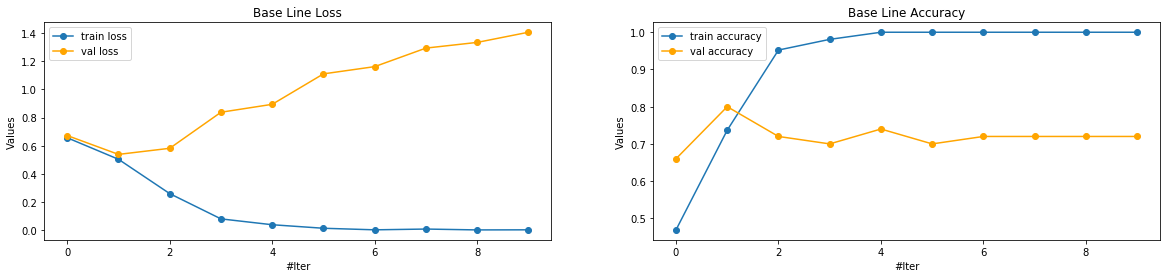

In [18]:
plot_plot(costs=train_losss_bl,acc_trains=acc_trains_bl,acc_vals=acc_vals_bl,val_costs=val_losss_bl,
          method="Base Line")

可以看到模型在2epoch的时候,validation data loss 开始上升模型开始过拟合.

#### L1 of Pytorch

In [19]:
layers = [20,7,5,1]
l1_model = Regularize_model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50,mode='l1_1')
acc_trains_l1,train_losss_l1,acc_vals_l1,val_losss_l1 = l1_model.fit(train_x,train_y,test_x,test_y)

Regularize(
  (lines): ModuleList(
    (0): Linear(in_features=12288, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=1, bias=True)
  )
)
[50/500] train loss:0.5047734379768372 train acc:0.6555023923444976 val loss:0.6030895709991455 val acc:0.34
[100/500] train loss:0.463291734457016 train acc:0.7129186602870813 val loss:0.6196205019950867 val acc:0.38
[150/500] train loss:0.3046336770057678 train acc:0.7464114832535885 val loss:0.6098249554634094 val acc:0.38
[200/500] train loss:0.024384288117289543 train acc:0.8421052631578947 val loss:0.3957348167896271 val acc:0.6
[250/500] train loss:0.10088805854320526 train acc:0.8564593301435407 val loss:0.35614970326423645 val acc:0.64
[300/500] train loss:0.01755218766629696 train acc:0.8660287081339713 val loss:0.3255983293056488 val acc:0.68
[350/500] train loss:0.17748545110225677 train acc:0.880382

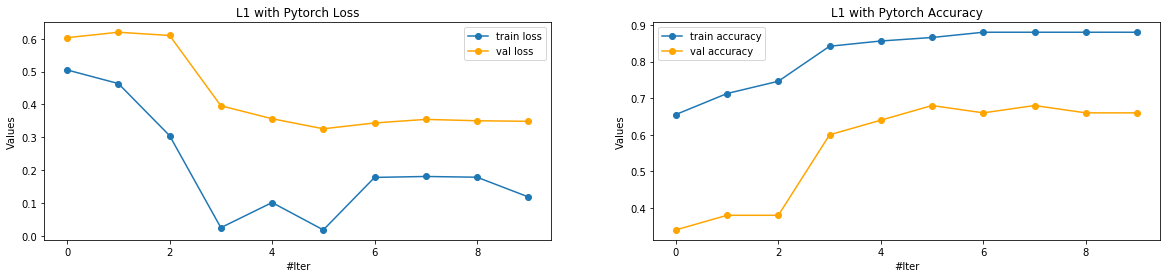

In [20]:
plot_plot(costs=train_losss_l1,acc_trains=acc_trains_l1,acc_vals=acc_vals_l1,val_costs=val_losss_l1,
          method="L1 with Pytorch")

可以看到使用```nn.L1Loss```是可以一定程度上减少模型过拟合的,且train/validation correct rate大幅度下降.所以Pytorch给出的建议是不要使用```nn.L1Loss```.

#### L1 with define.

In [21]:
layers = [20,7,5,1]
l1_2_model = Regularize_model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50,mode='l1_2')
acc_trains_l1_2,train_losss_l1_2,acc_vals_l1_2,val_losss_l1_2 = l1_2_model.fit(train_x,train_y,test_x,
                                                                           test_y,lambd = 0.1)

Regularize(
  (lines): ModuleList(
    (0): Linear(in_features=12288, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=1, bias=True)
  )
)
[50/500] train loss:15.559325218200684 train acc:0.5167464114832536 val loss:0.6785405874252319 val acc:0.62
[100/500] train loss:9.146347999572754 train acc:0.8038277511961722 val loss:0.6397800445556641 val acc:0.62
[150/500] train loss:5.245820999145508 train acc:0.6602870813397129 val loss:1.3543078899383545 val acc:0.34
[200/500] train loss:3.2823128700256348 train acc:0.6842105263157895 val loss:0.9184953570365906 val acc:0.34
[250/500] train loss:1.7867852449417114 train acc:0.7368421052631579 val loss:0.8834448456764221 val acc:0.4
[300/500] train loss:1.6038274765014648 train acc:0.7081339712918661 val loss:0.6063530445098877 val acc:0.82
[350/500] train loss:1.3877297639846802 train acc:0.8038277511961

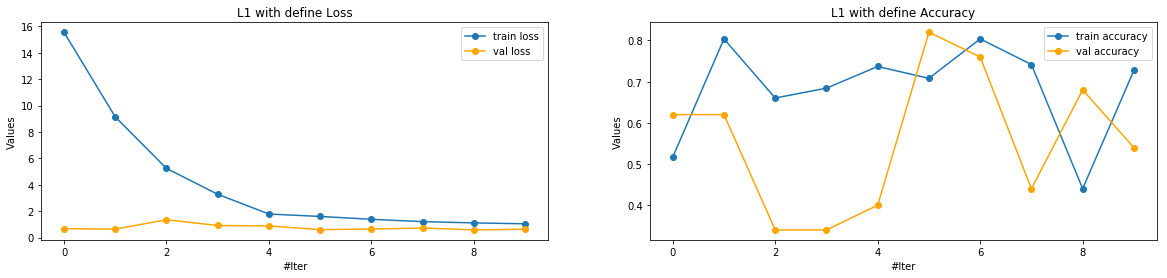

In [22]:
plot_plot(costs=train_losss_l1_2,acc_trains=acc_trains_l1_2,acc_vals=acc_vals_l1_2,val_costs=val_losss_l1_2,
          method="L1 with define")

可以看到,我们自定义的"L1",也起到了一定效果,但是train/validation data的correct rate都在浮动,所以"L1"并不是一个好选择.

#### L2 of Pytorch

In [23]:
layers = [20,7,5,1]
l2_model = Regularize_model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50,mode='l2_1')
acc_trains_l2,train_losss_l2,acc_vals_l2,val_losss_l2 = l2_model.fit(train_x,train_y,test_x,test_y,
                                                                     weight_decay = 0.1)

Regularize(
  (lines): ModuleList(
    (0): Linear(in_features=12288, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=1, bias=True)
  )
)
[50/500] train loss:0.6568589210510254 train acc:0.5167464114832536 val loss:0.6786025166511536 val acc:0.62
[100/500] train loss:0.5783696174621582 train acc:0.6028708133971292 val loss:0.5844560861587524 val acc:0.82
[150/500] train loss:0.36667513847351074 train acc:0.8133971291866029 val loss:0.6536605358123779 val acc:0.58
[200/500] train loss:0.2619689702987671 train acc:0.8277511961722488 val loss:0.6842027306556702 val acc:0.56
[250/500] train loss:0.5263481140136719 train acc:0.6794258373205742 val loss:1.3491334915161133 val acc:0.34
[300/500] train loss:0.2422984391450882 train acc:0.9234449760765551 val loss:0.6231185793876648 val acc:0.72
[350/500] train loss:0.24285297095775604 train acc:0.93301435

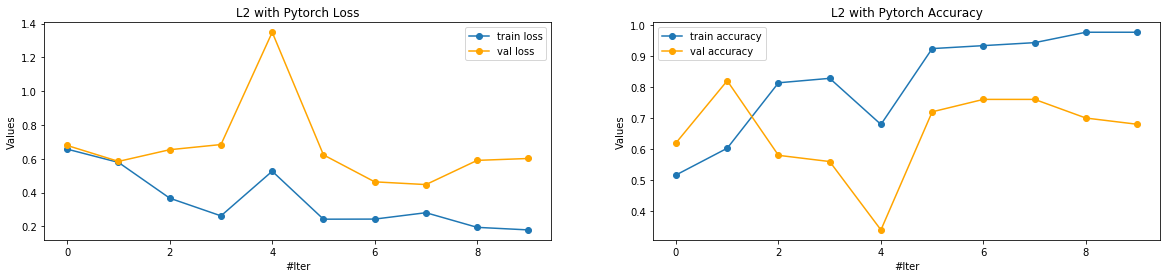

In [24]:
plot_plot(costs=train_losss_l2,acc_trains=acc_trains_l2,acc_vals=acc_vals_l2,val_costs=val_losss_l2,
          method="L2 with Pytorch")

可以看到,使用```weight_decay```的方式也在一定程度上减少了过拟合,但是在4个epoch的时候,会出现跌谷现象,个人认为这可能是weight decay所导致随机的梯度更新出现了误差,之后train/validation correct rate相比于"L1"稳定且正确率更高,但是此时模型依然处于过拟合状态.

#### L2 with define.

In [29]:
layers = [20,7,5,1]
l2_2_model = Regularize_model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50,mode='l2_2')
acc_trains_l2_2,train_losss_l2_2,acc_vals_l2_2,val_losss_l2_2 = l2_2_model.fit(train_x,train_y,test_x,
                                                                               test_y,lambd = 1.5)

Regularize(
  (lines): ModuleList(
    (0): Linear(in_features=12288, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=1, bias=True)
  )
)
[50/500] train loss:3.3244833946228027 train acc:0.45454545454545453 val loss:0.668515682220459 val acc:0.64
[100/500] train loss:2.809521198272705 train acc:0.8325358851674641 val loss:0.5448150038719177 val acc:0.74
[150/500] train loss:2.3198931217193604 train acc:0.8325358851674641 val loss:0.76458340883255 val acc:0.54
[200/500] train loss:1.9753835201263428 train acc:0.8708133971291866 val loss:0.7792621850967407 val acc:0.58
[250/500] train loss:1.8293790817260742 train acc:0.8421052631578947 val loss:1.0395509004592896 val acc:0.52
[300/500] train loss:1.5562689304351807 train acc:0.9856459330143541 val loss:0.7077813744544983 val acc:0.7
[350/500] train loss:1.3904147148132324 train acc:1.0 val loss:0.6

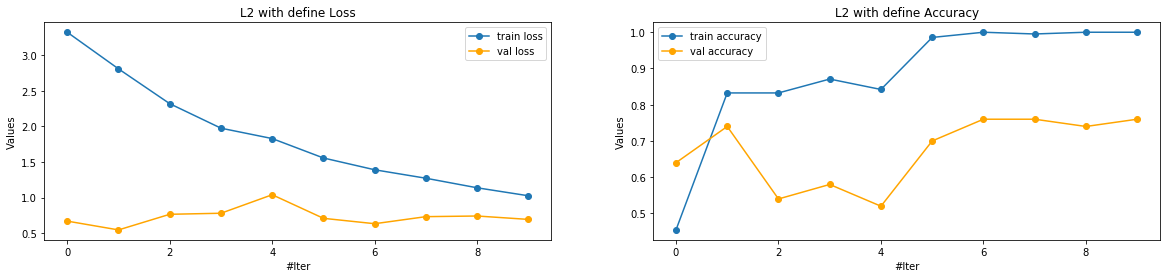

In [30]:
plot_plot(costs=train_losss_l2_2,acc_trains=acc_trains_l2_2,acc_vals=acc_vals_l2_2,val_costs=val_losss_l2_2,
          method="L2 with define")

可以看到自定义的"L2"也是可以减缓过拟合的,虽然整个模型还是处于过拟合阶段,但是相比于Base Line已经减缓了许多,且validation data correct rate 更加接近于training data correct rate.

在大约6个epoch的时候最优.

#### Dropout 

在我随机挑选的几组drop units中,以下是最优秀的,当然可能还有更好的选择比如CNN,更换layers,学习率等,但是这不是我们现在的侧重点,为了做对比,我们只更改p_delete_list参数.

In [37]:
layers = [20,7,5,1]
droput_model = Regularize_model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50,mode='dropout')
acc_trains_dp,train_losss_dp,acc_vals_dp,val_losss_dp = droput_model.fit(train_x,
                                                                         train_y,
                                                                         test_x,
                                                                         test_y,
                                                                         p_delete_list=[0.5,0.1,0])

Regularize(
  (lines): ModuleList(
    (0): Linear(in_features=12288, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=1, bias=True)
  )
  (dropouts): ModuleList(
    (0): Dropout(p=0.5)
    (1): Dropout(p=0.1)
    (2): Dropout(p=0)
  )
)
[50/500] train loss:0.6993775367736816 train acc:0.39712918660287083 val loss:0.6556006669998169 val acc:0.6
[100/500] train loss:0.6582624912261963 train acc:0.6985645933014354 val loss:0.7446050047874451 val acc:0.48
[150/500] train loss:0.46723631024360657 train acc:0.7894736842105263 val loss:0.6652886271476746 val acc:0.62
[200/500] train loss:0.29041120409965515 train acc:0.8516746411483254 val loss:0.7151693105697632 val acc:0.52
[250/500] train loss:0.39354804158210754 train acc:0.7607655502392344 val loss:1.1753554344177246 val acc:0.5
[300/500] train loss:0.3971153795719147 train acc:0.9138755980861244 v

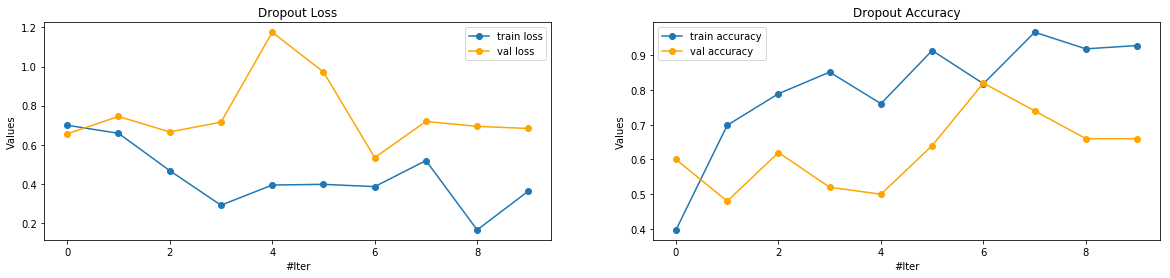

In [38]:
plot_plot(costs=train_losss_dp,acc_trains=acc_trains_dp,acc_vals=acc_vals_dp,val_costs=val_losss_dp,
          method="Dropout")

可以看到,相对于Base Lines效果也有改善,且大约在6个epoch的时候已经可以达到我们的"Best"模型(即train/validation correct rate极度相近)的要求(当然只是在当前所学的情况下).

### Summary

(1) 虽然Pytorch提供的L1并不友好,但是我们也很少会用到L1.

(2) 使用weights decay(权重衰减)的方式是和"L2"效果是等价的,因为我们的Regularization实际上做的就是权重衰减,只不过Regularization每次衰减是基于上一次迭代的$W$值而weights decay则是按照一个常值衰减.

(3) 不是说使用Regularization/Dropout就能起到完全解决过拟合的状态(即train/validation correct rate极度相近,也就是处于"Best"),两者只是一个优化方法,能够减缓模型过拟合.